In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
from copy import deepcopy
from bisect import bisect_left
import torch.nn as nn
import torch
import time
from collections import defaultdict
from IPython.display import clear_output

from lobio.lob.limit_order import Order, AMOUNT_TICK, PRICE_TICK, EventType, OrderType, TraderId, Side
from lobio.lob.order_book import  OrderBook, OrderBookSimple, OrderBookSimple2
from lobio.utils.utils import group_diffs, group_historical_trades, group_orders, get_initial_order_book
from queue_dynamic.models.models import GaussianPDFModel, ModelPerceptron, Critic
from queue_dynamic.simulation import run_true_simulation, run_pred_simulation
from queue_dynamic.losses import reinforce_objective, reinforce_objective_with_baseline, \
    critic_objective_td, critic_objective_mse, actor_objective, ppo_objective

sns.set_theme(style="darkgrid")

%load_ext line_profiler
%load_ext autoreload
%autoreload 2

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
diffs_prepared_file = "../data/diffs_prepared.npy"
init_lob_prepared_file = "../data/init_lob_prepared.npy"
orders_prepared_file = "../data/orders_prepared.npy"

pl_to_enter_file = "../data/price_level_to_enter.npy"

with open(init_lob_prepared_file, 'rb') as file:
    init_lob = np.load(file)
with open(diffs_prepared_file, 'rb') as file:
    diffs = np.load(file)
with open(orders_prepared_file, 'rb') as file:
    orders = np.load(file)

with open(pl_to_enter_file, 'rb') as file:
    pl_to_enter = np.load(file)

In [4]:
diffs_grouped = group_diffs(diffs)
orders_per_diff = group_orders(orders, len(diffs_grouped))
n_poses = len(pl_to_enter)

100%|██████████| 23209/23209 [00:00<00:00, 80555.70it/s]


In [71]:
dim_observation = 3
dim_action = 1
n_hidden_layers = 1
dim_hidden = 8
n_hidden_layers_critic = 1
dim_hidden_critic = 8
std = 0.01
scale_factor = 10
gamma = 0.95
lr_critic = 0.005
lr = 0.001
N_iter = 20
N_episode = 500
n_exp = 10
N_td = 1
N_critic_epoch = 30
epsilon = 0.2

In [68]:
seed = int(round(np.random.uniform(0, 10), 5) * 10**5)
torch.manual_seed(seed)
rng = np.random.default_rng(seed)

agent_network = ModelPerceptron(dim_observation, dim_action, dim_hidden=dim_hidden, n_hidden_layers=n_hidden_layers)
rl_agent = GaussianPDFModel(
    model=agent_network,
    dim_observation=dim_observation,
    dim_action=dim_action,
    action_bounds=np.array([[0, 1]]),
    scale_factor=scale_factor,
    std=std,
)

rl_critic = Critic(ModelPerceptron(dim_observation, 1, dim_hidden=dim_hidden_critic, n_hidden_layers=n_hidden_layers_critic))

optimizer_agent = torch.optim.SGD(rl_agent.parameters(), lr=lr)
optimizer_critic = torch.optim.SGD(rl_critic.parameters(), lr=lr_critic)

## Critic TD

In [23]:
running_loss = []
running_reward = []
for iter_num in range(N_iter):
    if iter_num % 10 == 0:
        clear_output(wait=True)
    samples_ind = np.unique(rng.integers(0, n_poses, size=N_episode))
    samples_ind.sort()
    samples = pl_to_enter[samples_ind]
    place_ratios = np.zeros(len(samples))
    
    poses_true_info = run_true_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rng)
    poses_pred_info, obs_actions = run_pred_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rl_agent)
    #precalculate all costs and observation in needed format
    all_episod_records = []
    all_costs_td = []
    all_costs_per_step = []
    reward = 0
    M = 0
    for i, episod_record in enumerate(obs_actions):
        all_episod_records.append(torch.FloatTensor(episod_record))
        costs_per_step = torch.ones(len(episod_record)) * (2 * (poses_true_info[i] != poses_pred_info[i]) - 1) / len(episod_record)
        if len(episod_record) > N_td:
            all_costs_td.append((costs_per_step[:-1].unfold(0, N_td, 1) * gamma**torch.arange(0, N_td)).sum(dim=1))
        else:
            all_costs_td.append(torch.Tensor([]))
        all_costs_per_step.append(costs_per_step)
        if not ((poses_true_info[i] == poses_pred_info[i] and poses_true_info[i] == -1) or \
                (poses_true_info[i] == poses_pred_info[i] and poses_true_info[i] == None)):
            if len(episod_record):
                reward += poses_true_info[i] == poses_pred_info[i]
                M += 1
    reward /= M

    all_episod_records = torch.concat(all_episod_records, dim=0)
    # critic train
    for _ in tqdm(range(N_critic_epoch)):
        #values = rl_critic(all_episod_records[:, :-1]) # last value - action
        running_idx = 0
        for i, episod_record in enumerate(obs_actions):
            if not ((poses_true_info[i] == poses_pred_info[i] and poses_true_info[i] == -1) or \
                    (poses_true_info[i] == poses_pred_info[i] and poses_true_info[i] == None)):
                if len(episod_record) > N_td:
                    values = rl_critic(all_episod_records[running_idx:running_idx+len(episod_record), :-1]).reshape(-1, )
                    optimizer_critic.zero_grad()
                    loss = critic_objective_td(all_costs_td[i], 
                                            values,#values[running_idx:running_idx+len(episod_record)],
                                            gamma, N_td)
                    loss.backward()
                    optimizer_critic.step()
                    #print(loss, values)
            running_idx += len(episod_record)
    # agent train
    optimizer_agent.zero_grad()
    loss = actor_objective(all_episod_records, poses_true_info, poses_pred_info,
                           obs_actions, all_costs_per_step, rl_agent, rl_critic, gamma)
    loss.backward()
    optimizer_agent.step()
    # # PPO train
    # optimizer_agent.zero_grad()
    #loss = ppo_objective(all_episod_records, poses_true_info, poses_pred_info,
    #                       obs_actions, all_costs_per_step, rl_agent, rl_critic, gamma, epsilon)
    # loss.backward()
    # optimizer_agent.step()

    running_loss.append(loss.item())
    running_reward.append(reward)

100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


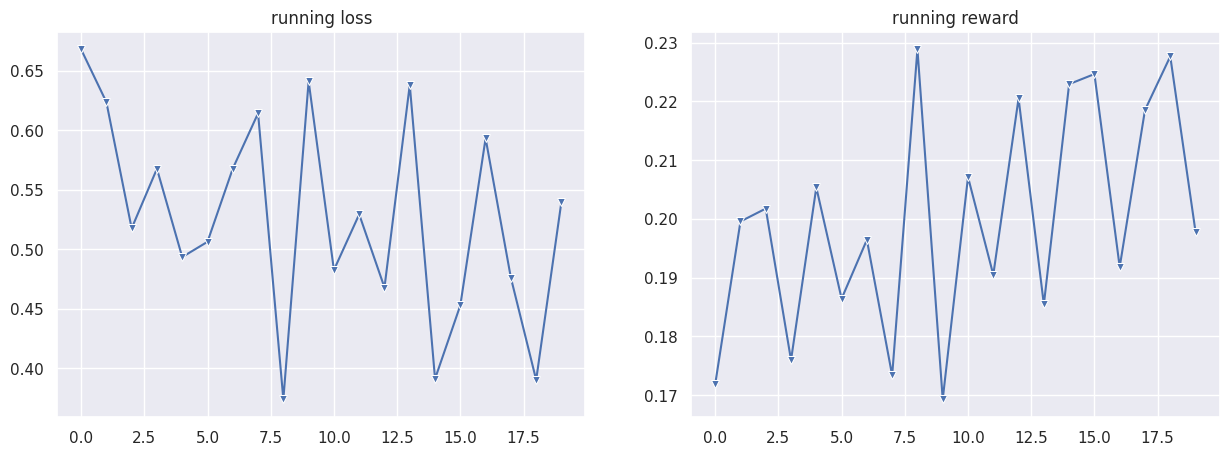

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(running_loss, marker='v', ax=axes[0])
axes[0].set_title('running loss')

sns.lineplot(running_reward, marker='v', ax=axes[1])
axes[1].set_title('running reward')

plt.show()

## Critic MSE

In [69]:
running_loss = []
running_reward = []
for iter_num in range(N_iter):
    if iter_num % 10 == 0:
        clear_output(wait=True)
    samples_ind = np.unique(rng.integers(0, n_poses, size=N_episode))
    samples_ind.sort()
    samples = pl_to_enter[samples_ind]
    place_ratios = np.zeros(len(samples))
    
    poses_true_info = run_true_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rng)
    poses_pred_info, obs_actions = run_pred_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rl_agent)
    #precalculate all costs and observation in needed format
    all_episod_records = []
    all_costs_mse = []
    all_costs_per_step = []
    reward = 0
    M = 0
    for i, episod_record in enumerate(obs_actions):
        all_episod_records.append(torch.FloatTensor(episod_record))
        costs_per_step = torch.ones(len(episod_record)) * (2 * (poses_true_info[i] != poses_pred_info[i]) - 1) / len(episod_record)
        if len(episod_record):
            episod_cost = (2 * (poses_true_info[i] != poses_pred_info[i]) - 1) / len(episod_record)
            coefs = gamma**torch.arange(0, len(episod_record))
            cum_sum = torch.cumsum(coefs, dim=0)
            reverse_cum_sum = coefs - cum_sum + cum_sum[-1]
            all_costs_mse.append(reverse_cum_sum / gamma**torch.arange(0, len(episod_record)) * episod_cost)
        else:
            all_costs_mse.append(torch.FloatTensor([]))
        all_costs_per_step.append(costs_per_step)
        if not ((poses_true_info[i] == poses_pred_info[i] and poses_true_info[i] == -1) or \
                (poses_true_info[i] == poses_pred_info[i] and poses_true_info[i] == None)):
            if len(episod_record):
                reward += poses_true_info[i] == poses_pred_info[i]
                M += 1
    reward /= M

    all_episod_records = torch.concat(all_episod_records, dim=0)
    # critic train

    for _ in tqdm(range(N_critic_epoch)):
        #values = rl_critic(all_episod_records[:, :-1]) # last value - action
        running_idx = 0

        for i, episod_record in enumerate(obs_actions):
            if not ((poses_true_info[i] == poses_pred_info[i] and poses_true_info[i] == -1) or \
                    (poses_true_info[i] == poses_pred_info[i] and poses_true_info[i] == None)):
                if len(episod_record):
                    values = rl_critic(all_episod_records[running_idx:running_idx+len(episod_record), :-1]).reshape(-1, )
                    optimizer_critic.zero_grad()
                    loss = critic_objective_mse(all_costs_mse[i], 
                                            values)
                    loss.backward()
                    optimizer_critic.step()

                    #print(loss, values)

            running_idx += len(episod_record)
    # agent train
    optimizer_agent.zero_grad()
    loss = actor_objective(all_episod_records, poses_true_info, poses_pred_info,
                           obs_actions, all_costs_per_step, rl_agent, rl_critic, gamma)
    loss.backward()
    optimizer_agent.step()
    # # PPO train
    # optimizer_agent.zero_grad()
    #loss = ppo_objective(all_episod_records, poses_true_info, poses_pred_info,
    #                       obs_actions, all_costs_per_step, rl_agent, rl_critic, gamma, epsilon)
    # loss.backward()
    # optimizer_agent.step()

    running_loss.append(loss.item())
    running_reward.append(reward)

100%|██████████| 30/30 [00:11<00:00,  2.53it/s]


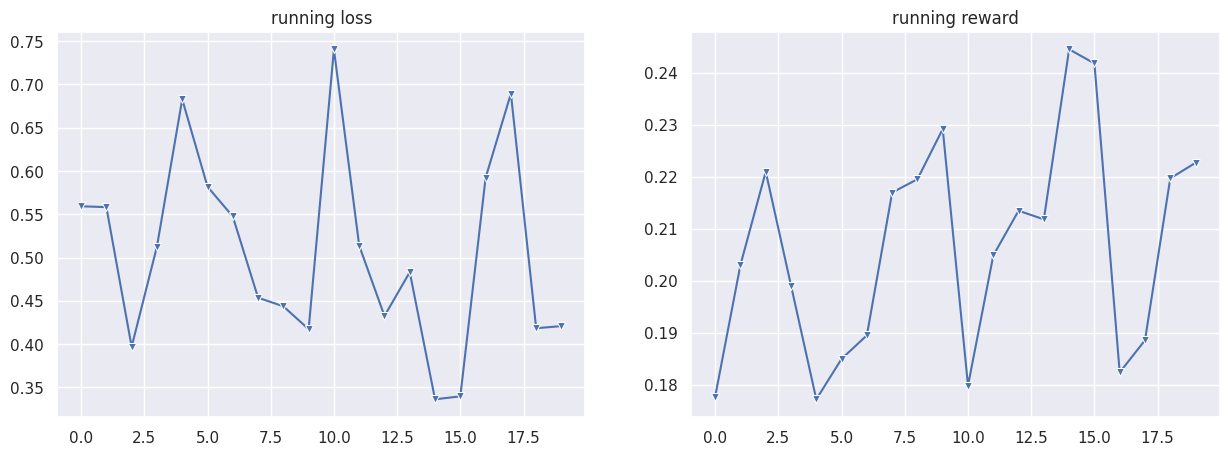

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(running_loss, marker='v', ax=axes[0])
axes[0].set_title('running loss')

sns.lineplot(running_reward, marker='v', ax=axes[1])
axes[1].set_title('running reward')

plt.show()